In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

def import_data(ticker=str, start=str, end=str):
    ticker = ticker.upper()
    df = yf.download(ticker, start, end, progress=False)
    df = df.dropna()
    df['Date'] = df.index
    df.index = range(0, len(list(df.index)))
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return df

def add_indicators(dataframe, BB=bool, BBperiod=20, BBstd=2.0, 
                   DC=bool, DCperiod=20, 
                   KC=bool, KCperiod=20, KCnormalized=False, KCatr=10, KCog=True, 
                   PSAR=bool, PSARiaf=0.02, PSARmaf=0.2, 
                   MACD=bool, MACDslow=26, MACDfast=12, MACDsign=9, 
                   IC=bool, ICleadingB=52, ICbase=26, ICconv=9, fillna=bool):

    if BB == True:
        def add_bollinger_bands(df, period, std):
            from ta.volatility import BollingerBands
            indicator_bb = BollingerBands(close=df['Close'], window=period, window_dev=std)
            df['BB_Middle'] = indicator_bb.bollinger_mavg()
            df['BB_Upper'] = indicator_bb.bollinger_hband()
            df['BB_Lower'] = indicator_bb.bollinger_lband()
            return None
        add_bollinger_bands(dataframe, BBperiod, BBstd)
    
    if DC == True:
        def add_donchian_channel(df, period):
            from ta.volatility import DonchianChannel
            indicator_dc = DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=DCperiod, offset=0, fillna=False)
            df['DC_Middle'] = indicator_dc.donchian_channel_mband()
            df['DC_Upper'] = indicator_dc.donchian_channel_hband()
            df['DC_Lower'] = indicator_dc.donchian_channel_lband()
            return None
        add_donchian_channel(dataframe, DCperiod)
    
    if KC == True:
        def add_keltner_channel(df, period, atrperiod, normalized, ogversion):
            from ta.volatility import KeltnerChannel
            indicator_kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'], window=period, window_atr=atrperiod, fillna=False, original_version=ogversion)
            df['KC_Middle'] = indicator_kc.keltner_channel_mband()
            if normalized == True:
                from talib import NATR
                df['NATR'] = list(NATR(df['High'], df['Low'], df['Close'], timeperiod=atrperiod))
                df['KC_Upper'] = [price*(1+(df['NATR'][n]/100)) for n, price in enumerate(list(df['KC_Middle']))]
                df['KC_Lower'] = [price*(1-(df['NATR'][n]/100)) for n, price in enumerate(list(df['KC_Middle']))]
            else:
                from talib import ATR
                df['ATR'] = list(ATR(df['High'], df['Low'], df['Close'], timeperiod=atrperiod))
                df['KC_Upper'] = indicator_kc.keltner_channel_hband()
                df['KC_Lower'] = indicator_kc.keltner_channel_lband()
        add_keltner_channel(dataframe, KCperiod, KCatr, KCnormalized, KCog)
        
    if PSAR == True:
        def add_parabolic_sar(df, iaf, maf):
            from ta.trend import PSARIndicator
            indicator_psar = PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'], step=iaf, max_step=maf, fillna=False)
            df['PSAR_All'] = indicator_psar.psar()
            df['PSAR_Bull'] = indicator_psar.psar_up()
            df['PSAR_Bear'] = indicator_psar.psar_down()
            return None
        add_parabolic_sar(dataframe, PSARiaf, PSARmaf)
    
    if MACD == True:
        def add_macd(df, slow, fast, sign):
            from ta.trend import MACD
            indicator_macd = MACD(close=df['Close'], window_slow=slow, window_fast=fast, window_sign=sign, fillna=True)
            df['MACD_Main'] = indicator_macd.macd()
            df['MACD_Signal'] = indicator_macd.macd_signal()
            df['MACD_Volume'] = indicator_macd.macd_diff()
            MACD_Volume = [volume for volume in df['MACD_Volume']]
            MACD_Volume_Positive = []
            MACD_Volume_Negative = []
            for n, volume in enumerate(MACD_Volume):
                if (volume < 0):
                    MACD_Volume_Positive.append(0)
                    MACD_Volume_Negative.append(volume)
                elif (volume >= 0):
                    MACD_Volume_Positive.append(volume)
                    MACD_Volume_Negative.append(0)
            df['Volume_Positive'] = MACD_Volume_Positive
            df['Volume_Negative'] = MACD_Volume_Negative
            return None
        add_macd(dataframe, MACDslow, MACDfast, MACDsign)
        
    if IC == True:
        def add_ichimoku_cloud(df, conv, base, leadingB):
            from ta.trend import IchimokuIndicator
            indicator_ic = IchimokuIndicator(high=df['High'], low=df['Low'], window1=conv, window2=base, window3=leadingB, visual=True, fillna=False)
            df['IC_Conv'] = indicator_ic.ichimoku_conversion_line()
            df['IC_Base'] = indicator_ic.ichimoku_base_line()
            df['IC_LeadingA'] = indicator_ic.ichimoku_a()
            df['IC_LeadingB'] = indicator_ic.ichimoku_b()
            return None
        add_ichimoku_cloud(dataframe, ICconv, ICbase, ICleadingB)
        
    if fillna == True:
        dataframe = dataframe.fillna(0)
    return dataframe

In [2]:
def keltner_psar(df):
    Dates = [date for date in df['Date']]
    Prices = [price for price in df['Close']]
    KC_Upper = [price for price in df['KC_Upper']]
    KC_Middle = [price for price in df['KC_Middle']]
    KC_Lower = [price for price in df['KC_Lower']]
    PSAR_All = [price for price in df['PSAR_All']]
    PSAR_Bear = [price for price in df['PSAR_Bear']]
    PSAR_Bull = [price for price in df['PSAR_Bull']]

    long_position = False
    short_position = False
    entrance_index = 0
    long_waiting_period = 0
    short_waiting_period = 0
    long_entrance_price = 0
    short_entrance_price = 0
    total_profits = 0
    shares = 2

    for n, price in enumerate(Prices):
        if long_position == True:
            if (PSAR_Bear[n] != 0) and (PSAR_Bull[n-1] != 0):
                print(" -- cover signal --")
                print(f"PSAR switch to bear at ${price} on {Dates[n].date()}")
                total_profits += price*shares - long_entrance_price*shares
                performance = total_profits/(long_entrance_price*shares)
                print(f" -> current profits: {total_profits} | performance: {round(performance,2)}% | timeframe: {n-entrance_index} trading days")
                long_position=False
                pass
        if short_position == True:
            if (PSAR_Bull[n] != 0) and (PSAR_Bear[n-1] != 0):
                print(" -- cover signal --")
                print(f"PSAR switch to bull at ${price} on {Dates[n].date()}")
                total_profits += short_entrance_price*shares - price*shares
                performance = total_profits/(short_entrance_price*shares)
                print(f" -> current profits: {total_profits} | performance: {round(performance,2)}% | timeframe: {n-entrance_index} trading days")
                short_position=False
                pass
        if (price > KC_Upper[n] and Prices[n-1] < KC_Upper[n-1]):
            if long_position == False:
                if short_position == True:
                    print(" -- cover and buy signal --")
                    print(f"Breakout Above at ${price} on {Dates[n].date()}")
                    total_profits += short_entrance_price*shares - price*shares
                    performance = total_profits/(short_entrance_price*shares)
                    print(f" -> current profits: {total_profits} | performance: {round(performance,2)}% | timeframe: {n-entrance_index} trading days")
                    entrance_index = n
                    long_entrance_price = price
                    short_position = False
                    long_position = True
                elif short_position == False:
                    print(" -- buy signal --")
                    print(f"Breakout Above at ${price} on {Dates[n].date()}")
                    entrance_index = n
                    long_entrance_price = price
                    long_position = True
        if (price < KC_Lower[n] and Prices[n-1] > KC_Lower[n-1]):
            if short_position == False:
                if long_position == True:
                    print(" -- cover and sell signal --")
                    print(f"Breakout Below at ${price} on {Dates[n].date()}")
                    total_profits += price*shares - long_entrance_price*shares
                    performance = total_profits/(long_entrance_price*shares)
                    print(f" -> current profits: {total_profits} | performance: {round(performance,2)}% | timeframe: {n-entrance_index} trading days")
                    entrance_index = n
                    short_entrance_price = price
                    long_position = False
                    short_position = True
                elif long_position == False:
                    print(" -- sell signal --")
                    print(f"Breakout Below at ${price} on {Dates[n].date()}")
                    entrance_index = n
                    short_entrance_price = price
                    short_position = True

    return print(f"TOTAL PROFITS: ${total_profits}")

def psar_macd(df):
    Dates = [date for date in df['Date']]
    Prices = [price for price in df['Close']]
    PSAR_Bear = [price for price in df['PSAR_Bear']]
    PSAR_Bull = [price for price in df['PSAR_Bull']]
    MACD_Main = [level for level in df['MACD_Main']]
    MACD_Signal = [level for level in df['MACD_Signal']]

    crossovers_above = 0
    crossovers_below = 0
    crossover_count = 0
    long_position = False
    short_position = False
    long_waiting_period = 0
    short_waiting_period = 0
    long_entrance_price = 0
    short_entrance_price = 0
    total_profits = 0
    shares = 2

    for n, price in enumerate(Prices):
        if (long_position == True):
            if (long_waiting_period == 0):
                if ((MACD_Main[n-4] >= MACD_Signal[n-4]) and (MACD_Main[n-5] < MACD_Signal[n-5])) or ((MACD_Main[n-3] >= MACD_Signal[n-3]) and (MACD_Main[n-4] < MACD_Signal[n-4])) or ((MACD_Main[n-2] >= MACD_Signal[n-2]) and (MACD_Main[n-3] < MACD_Signal[n-3])) or ((MACD_Main[n-1] >= MACD_Signal[n-1]) and (MACD_Main[n-2] < MACD_Signal[n-2])) or ((MACD_Main[n] >= MACD_Signal[n]) and (MACD_Main[n-1] < MACD_Signal[n-1])):
                    print(f"MACD mainline crossover from BELOW on {Dates[n].date()}")
                    long_waiting_period -= 1
                    continue
                else:
                    print(" -- cancel/cover signal --")
                    print(f"MACD unchanged at ${price} on {Dates[n].date()}")
                    total_profits += (price*shares) - (long_entrance_price*shares)
                    print(f" -> current profits: {total_profits}")
                    long_position = False
                    long_waiting_period -= 1
                    pass
            elif (long_waiting_period > 0):
                long_waiting_period -= 1
        if (short_position == True):
            if (short_waiting_period == 0):
                if ((MACD_Main[n-4] < MACD_Signal[n-4]) and (MACD_Main[n-5] >= MACD_Signal[n-5])) or ((MACD_Main[n-3] < MACD_Signal[n-3]) and (MACD_Main[n-4] >= MACD_Signal[n-4])) or ((MACD_Main[n-2] < MACD_Signal[n-2]) and (MACD_Main[n-3] >= MACD_Signal[n-3])) or ((MACD_Main[n-1] < MACD_Signal[n-1]) and (MACD_Main[n-2] >= MACD_Signal[n-2])) or ((MACD_Main[n] < MACD_Signal[n]) and (MACD_Main[n-1] >= MACD_Signal[n-1])):
                    print(f"MACD mainline crossover from ABOVE on {Dates[n].date()}")
                    short_waiting_period -= 1
                    continue
                else:
                    print(" -- cancel/cover signal --")
                    print(f"MACD unchanged at ${price} on {Dates[n].date()}")
                    total_profits += (short_entrance_price*shares) - (price*shares)
                    print(f" -> current profits: {total_profits}")
                    short_position = False
                    short_waiting_period -= 1
                    pass
            elif (short_waiting_period > 0):
                short_waiting_period -= 1
        if (PSAR_Bull[n] != 0) and (PSAR_Bear[n-1] != 0):
            if short_position == True:
                print(" -- cover and buy signal --")
                print(f"Switch to bull at ${price} on {Dates[n].date()}")
                total_profits += short_entrance_price*shares - price*shares
                print(f" -> current profits: {total_profits}")
                long_entrance_price = price
                long_waiting_period = 4
                short_position = False
                long_position = True
            elif short_position == False:
                print(" -- buy signal --")
                print(f"Switch to bull at ${price} on {Dates[n].date()}")
                long_entrance_price = price
                long_waiting_period = 4
                long_position = True
        if (PSAR_Bear[n] != 0) and (PSAR_Bull[n-1] != 0):
            if long_position == True:
                print(" -- cover and sell signal --")
                print(f"Switch to bear at ${price} on {Dates[n].date()}")
                total_profits += price*shares - short_entrance_price*shares
                print(f" -> current profits: {total_profits}")
                short_entrance_price = price
                short_waiting_period = 4
                long_position = False
                short_position = True
            elif long_position == False:
                print(" -- sell signal --")
                print(f"Switch to bear at ${price} on {Dates[n].date()}")
                short_entrance_price = price
                short_waiting_period = 4
                short_position = True
           
    return print(f"TOTAL PROFITS: ${total_profits}")

def natr_macd(df):
    Dates = [date for date in df['Date']]
    Prices = [price for price in df['Close']]
    NATR = [level for level in df['NATR']]
    MACD_Main = [level for level in df['MACD_Main']]
    MACD_Signal = [level for level in df['MACD_Signal']]

    Main_NATR_above = 0
    Main_NATR_below = 0
    Main_Signal_above = 0
    Main_Signal_below = 0
    Main_NATR_count = 0
    Main_Signal_count = 0
    long_position = False
    short_position = False
    long_entrance_price = 0
    short_entrance_price = 0
    total_profits = 0
    shares = 2

    for n, price in enumerate(Prices):
        if (long_position == True):
            if ((MACD_Signal[n-1] < MACD_Main[n-1]) and (MACD_Signal[n] > MACD_Main[n])):
                print(" -- cover signal --")
                print(f"Signal-Main negative crossover ${price} on {Dates[n].date()}")
                total_profits += price*shares - long_entrance_price*shares
                print(f" -> current profits: {total_profits}")
                long_position=False
                pass
        if (short_position == True):
            if ((MACD_Signal[n-1] > MACD_Main[n-1]) and (MACD_Signal[n] < MACD_Main[n])):
                print(" -- cover signal --")
                print(f"Signal-Main positive crossover at ${price} on {Dates[n].date()}")
                total_profits += short_entrance_price*shares - price*shares
                print(f" -> current profits: {total_profits}")
                short_position=False
                pass
        if ((NATR[n-1] > MACD_Main[n-1]) and (NATR[n] < MACD_Main[n])):
            if long_position == False:
                if short_position == True:
                    print(" -- cover and buy signal --")
                    print(f"NATR-Main positive crossover at ${price} on {Dates[n].date()}")
                    total_profits += short_entrance_price*shares - price*shares
                    print(f" -> current profits: {total_profits}")
                    long_entrance_price = price
                    short_position = False
                    long_position = True
                elif short_position == False:
                    print(" -- buy signal --")
                    print(f"NATR-Main positive crossover at ${price} on {Dates[n].date()}")
                    long_entrance_price = price
                    long_position = True
        if ((NATR[n-1] < MACD_Main[n-1]) and (NATR[n] > MACD_Main[n])):
            if short_position == False:
                if long_position == True:
                    print(" -- cover and sell signal --")
                    print(f"NATR-Main negative crossover at ${price} on {Dates[n].date()}")
                    total_profits += price*shares - long_entrance_price*shares
                    print(f" -> current profits: {total_profits}")
                    short_entrance_price = price
                    long_position = False
                    short_position = True
                elif long_position == False:
                    print(" -- sell signal --")
                    print(f"NATR-Main negative crossover at ${price} on {Dates[n].date()}")
                    short_entrance_price = price
                    short_position = True
                    
    return print(f"TOTAL PROFITS: ${total_profits}")

In [25]:
params = ['msft','2020-10-21','2021-10-21']
keltner_psar(add_indicators(import_data(params[0], params[1], params[2]), KC=True, KCperiod=14, KCnormalized=True, KCatr=10, PSAR=True, PSARiaf=0.025, PSARmaf=0.25, fillna=True))
print("\n")
psar_macd(add_indicators(import_data(params[0], params[1], params[2]), PSAR=True, PSARiaf=0.02, PSARmaf=0.2, MACD=True, MACDslow=26, MACDfast=12, MACDsign=9, fillna=True))
print("\n")
natr_macd(add_indicators(import_data(params[0], params[1], params[2]), MACD=True, MACDslow=26, MACDfast=12, MACDsign=9, KC=True, KCnormalized=True, fillna=True))


 -- sell signal --
Breakout Below at $210.11000061035156 on 2020-11-23
 -- cover signal --
PSAR switch to bull at $216.00999450683594 on 2020-12-08
 -> current profits: -11.79998779296875 | performance: -0.03% | timeframe: 10 trading days
 -- buy signal --
Breakout Above at $219.27999877929688 on 2020-12-16
 -- cover signal --
PSAR switch to bear at $222.4199981689453 on 2020-12-31
 -> current profits: -5.519989013671875 | performance: -0.01% | timeframe: 10 trading days
 -- sell signal --
Breakout Below at $212.25 on 2021-01-06
 -- cover signal --
PSAR switch to bull at $224.33999633789062 on 2021-01-20
 -> current profits: -29.699981689453125 | performance: -0.07% | timeframe: 9 trading days
 -- buy signal --
Breakout Above at $224.33999633789062 on 2021-01-20
 -- cover signal --
PSAR switch to bear at $244.1999969482422 on 2021-02-17
 -> current profits: 10.02001953125 | performance: 0.02% | timeframe: 19 trading days
 -- sell signal --
Breakout Below at $234.50999450683594 on 2021-

/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


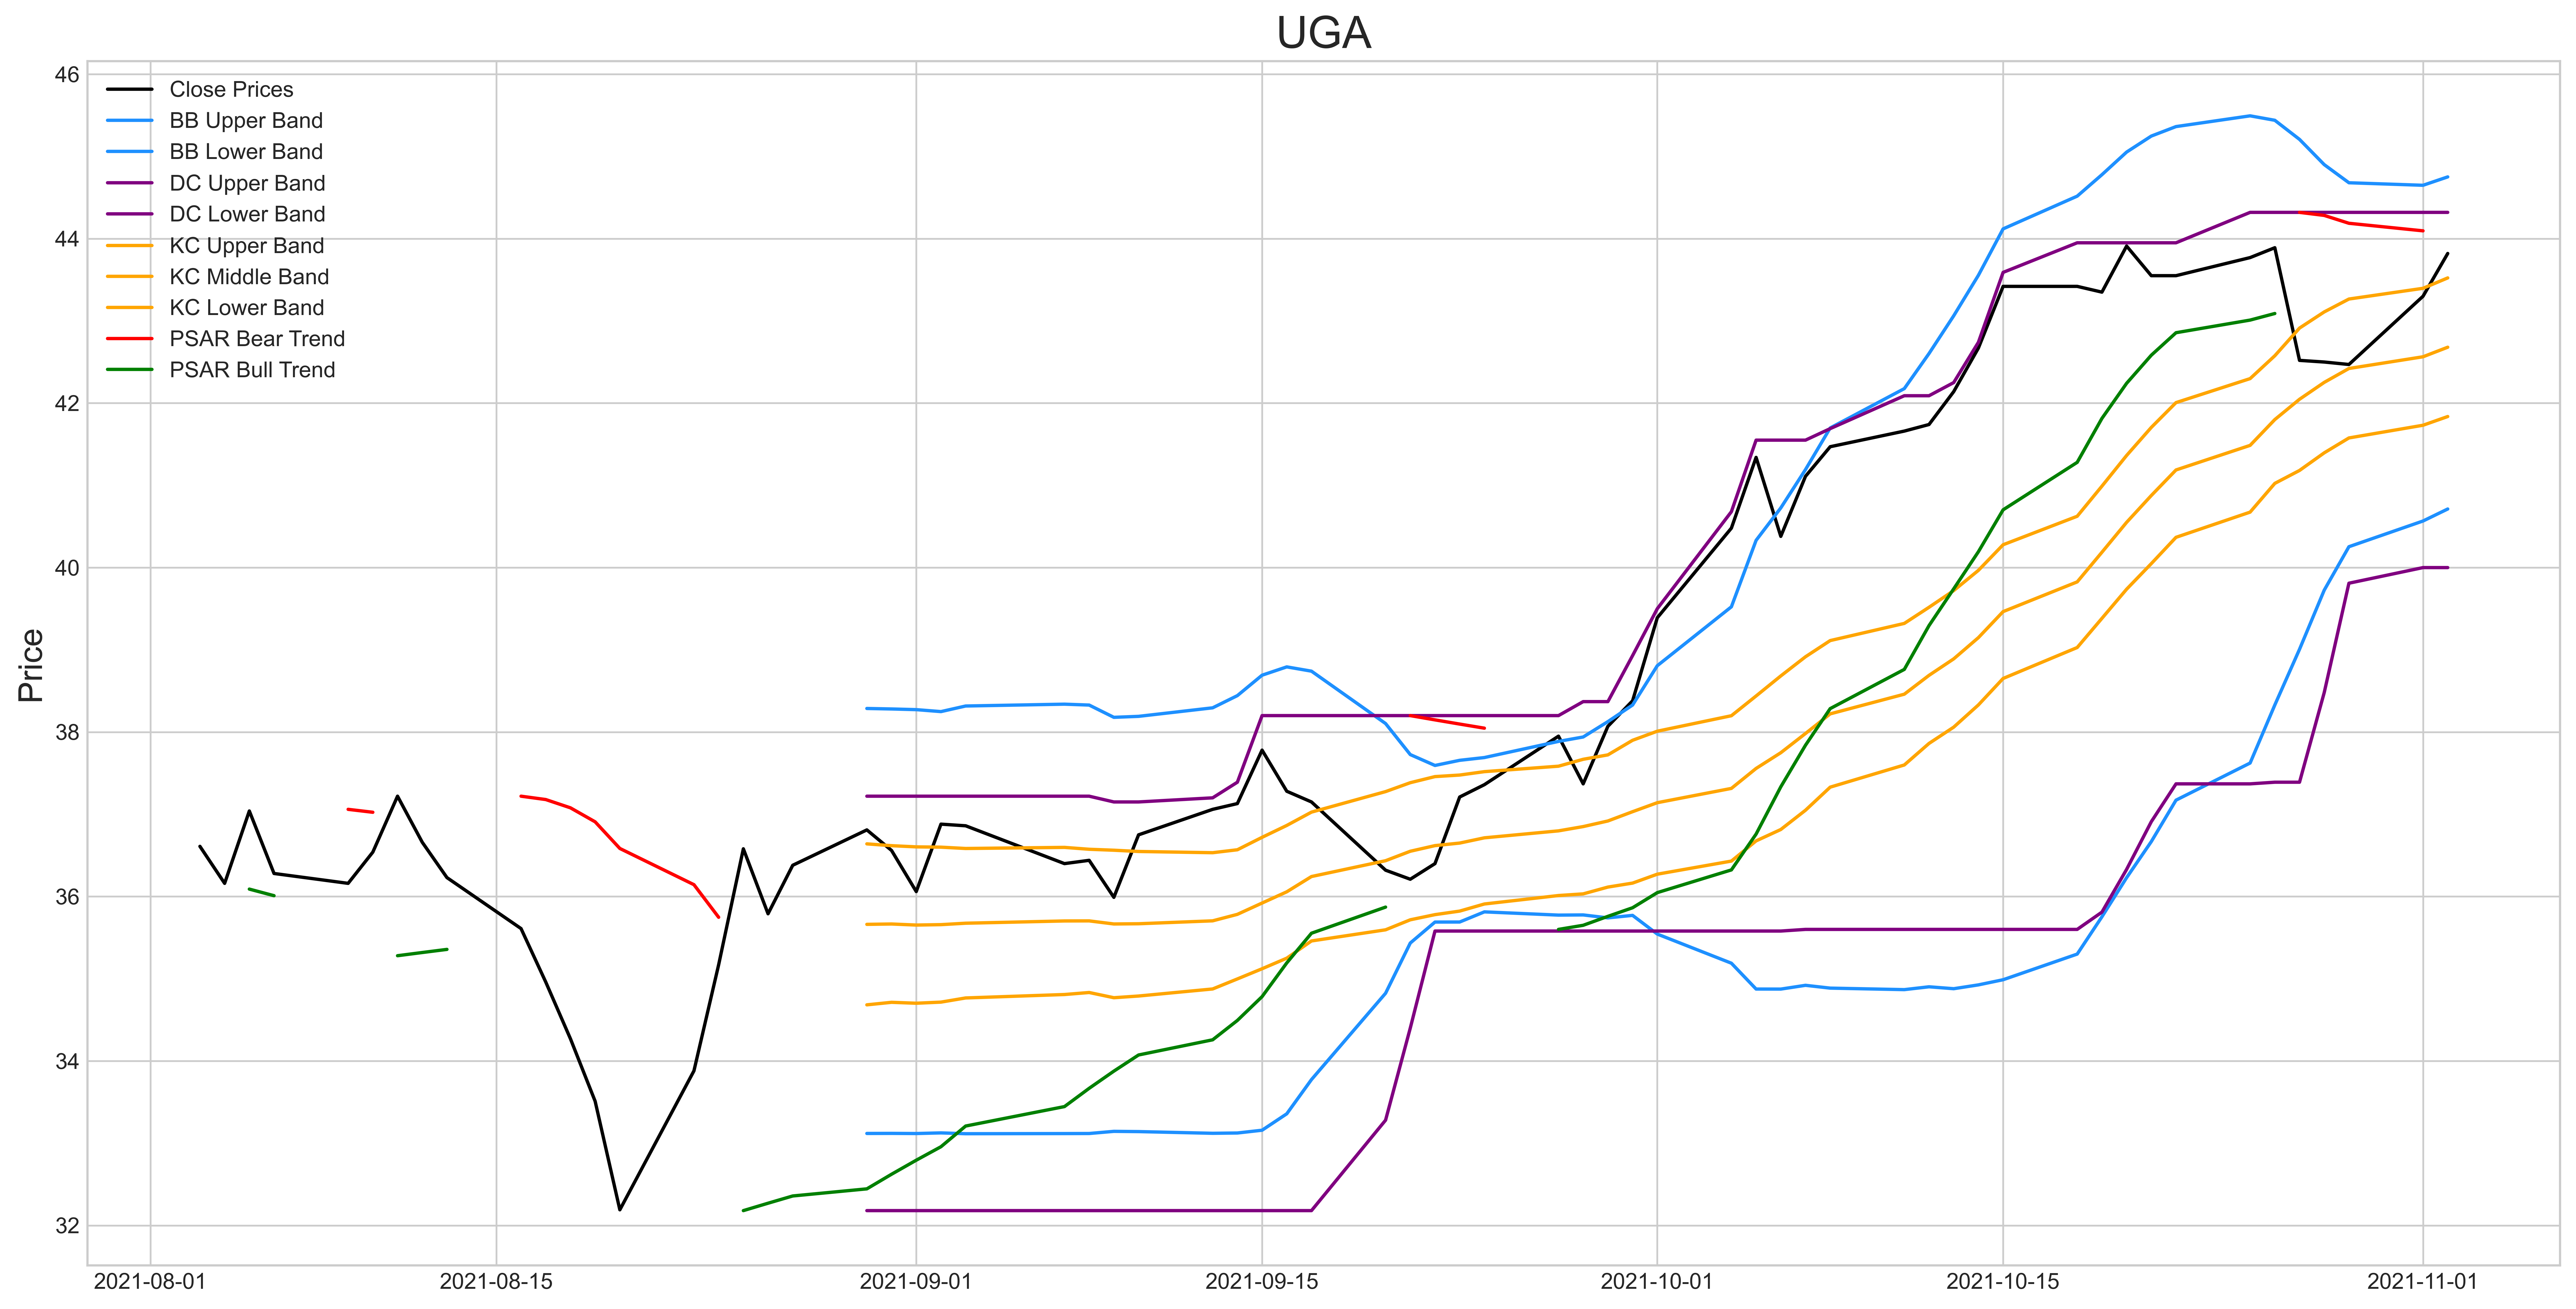

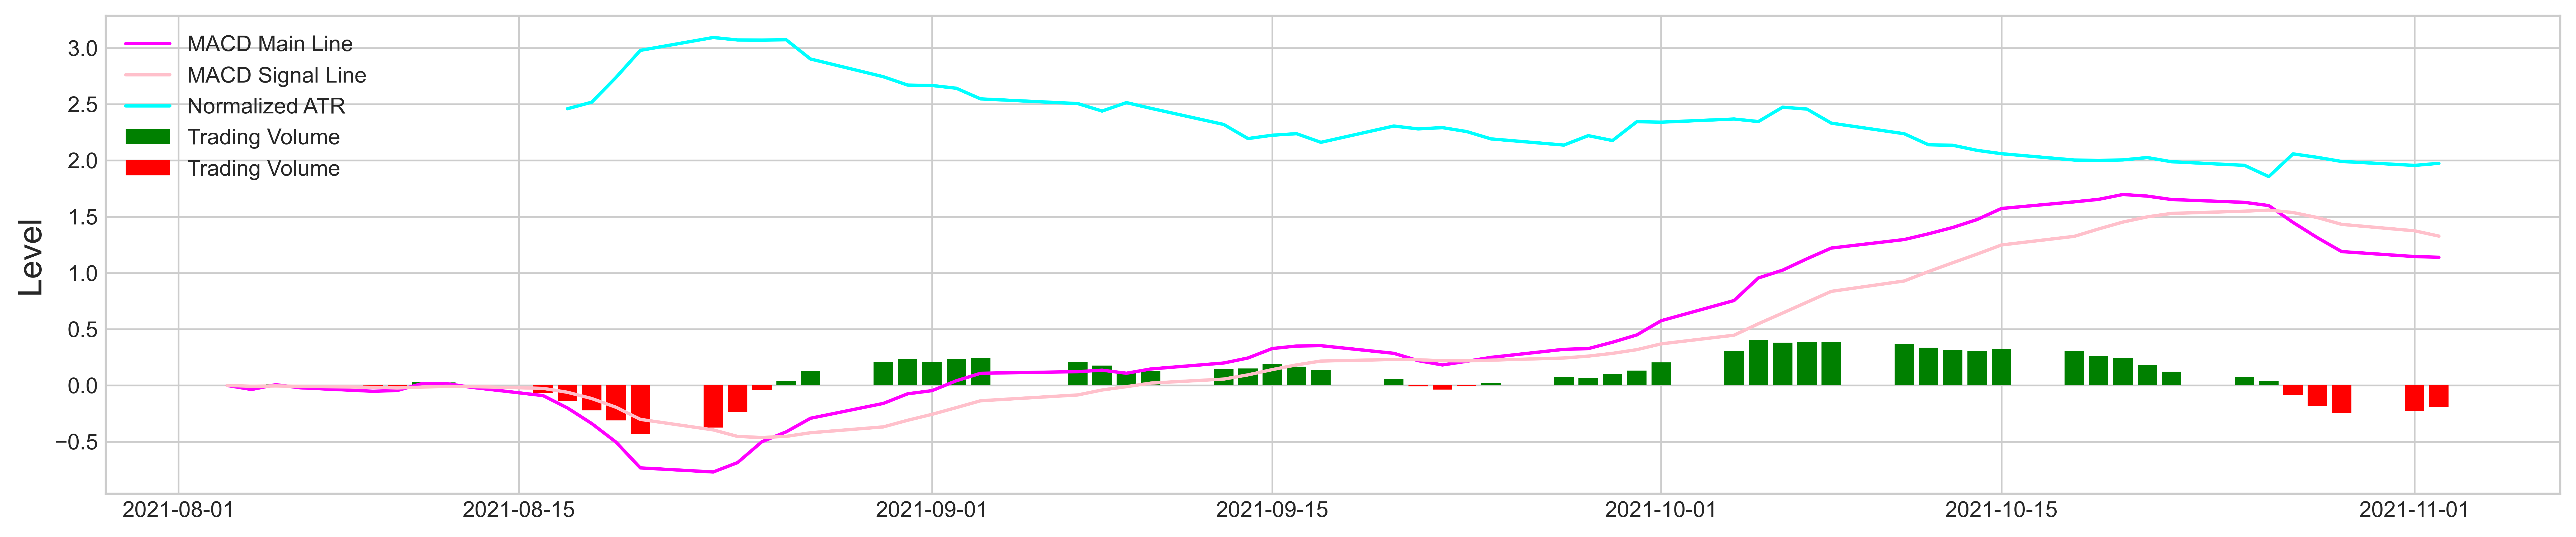

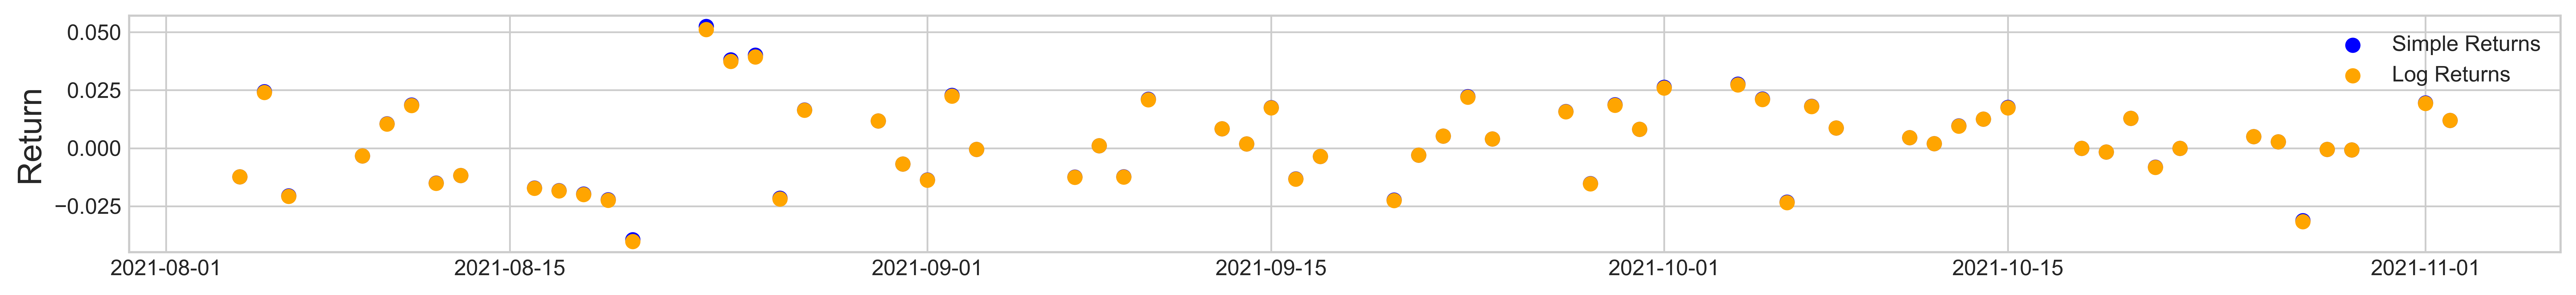

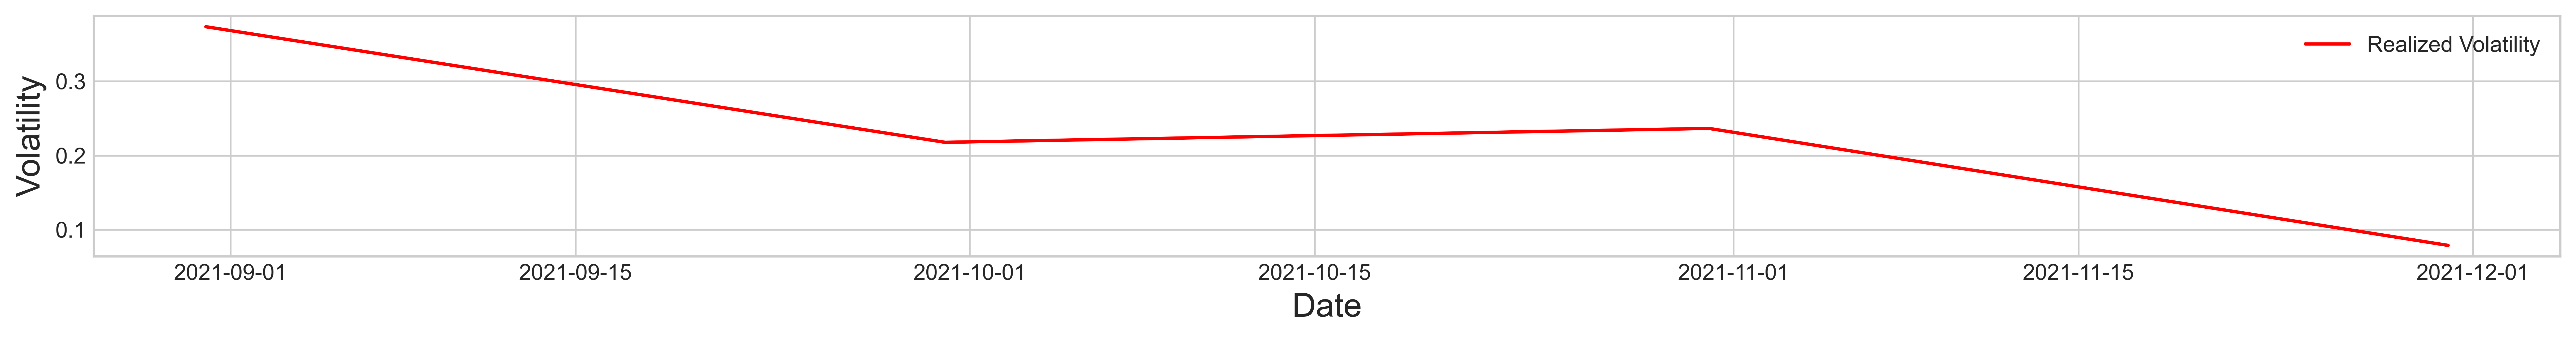

In [4]:
params = ['uga','2021-08-03','2021-11-03', True]
df = add_indicators(import_data(params[0], params[1], params[2]), BB=True, DC=True, KC=True, KCnormalized=params[3], PSAR=True, MACD=True, fillna=False)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.Date, df['Close'], label='Close Prices', color='black')
# Bollinger Band
ax.plot(df.Date, df['BB_Upper'], label='BB Upper Band', color='dodgerblue')
ax.plot(df.Date, df['BB_Lower'], label='BB Lower Band', color='dodgerblue')
# Donchian Channel
ax.plot(df.Date, df['DC_Upper'], label='DC Upper Band', color='purple')
ax.plot(df.Date, df['DC_Lower'], label='DC Lower Band', color='purple')
# Keltner Channel
ax.plot(df.Date, df['KC_Upper'], label='KC Upper Band', color='orange')
ax.plot(df.Date, df['KC_Middle'], label='KC Middle Band', color='orange')
ax.plot(df.Date, df['KC_Lower'], label='KC Lower Band', color='orange')
# Parabolic Stop and Reverse
ax.plot(df.Date, df['PSAR_Bear'], label='PSAR Bear Trend', color='red')
ax.plot(df.Date, df['PSAR_Bull'], label='PSAR Bull Trend', color='green')
ax.set_ylabel('Price', size=15)
ax.set_title(params[0].upper(), size=20)
ax.legend()

fig, ax = plt.subplots(figsize=(20, 4))
# Moving Average Convergence/Diversgence
ax.plot(df.Date, df['MACD_Main'], label='MACD Main Line', color='magenta')
ax.plot(df.Date, df['MACD_Signal'], label='MACD Signal Line', color='pink')
if params[3] == True:
    # Normalized Average True Range
    ax.plot(df.Date, df['NATR'], label='Normalized ATR', color='cyan')
elif params[3] == False:
    # Average True Range
    ax.plot(df.Date, df['ATR'], label='Average True Range', color='cyan')
# Trading Volume
ax.bar(df.Date, df['Volume_Positive'], label='Trading Volume', color='green')
ax.bar(df.Date, df['Volume_Negative'], label='Trading Volume', color='red')

ax.set_ylabel('Level', size=15)
ax.legend()

# Simple and Log Returns
df = yf.download(params[0], params[1], params[2], progress=False)
df['Simple_Return'] = df['Adj Close'].pct_change()
df['Log_Return'] = np.log(df['Adj Close']/df['Close'].shift(1))
fig, ax = plt.subplots(figsize=(20, 2))
ax.scatter(df.index, df['Simple_Return'], label='Simple Returns', color='blue')
ax.scatter(df.index, df['Log_Return'], label='Log Returns', color='orange')
ax.set_ylabel('Return', size=15)
ax.legend()

# Realized Volatility
df = pd.DataFrame(df['Log_Return']).fillna(0)
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'Log_Return':'Realized_Volatility'}, inplace=True)
df_rv['Realized_Volatility'] = df_rv['Realized_Volatility'] * np.sqrt(12)
fig, ax = plt.subplots(figsize=(20, 2))
ax.plot(df_rv.index, df_rv['Realized_Volatility'], label='Realized Volatility', color='red')
ax.set_ylabel('Volatility', size=15)
ax.set_xlabel('Date', size=15)
ax.legend()